In [1]:
pip install tensorflow keras opencv-python scikit-learn matplotlib numpy

  Using cached scikit_learn-1.6.1-cp312-cp312-win_amd64.whl.metadata (15 kB)
  Using cached matplotlib-3.10.0-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Using cached scipy-1.15.1-cp312-cp312-win_amd64.whl.metadata (60 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
  Using cached contourpy-1.3.1-cp312-cp312-win_amd64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.8-cp312-cp312-win_amd64.whl.metadata (6.3 kB)
  Using cached pyparsing-3.2.1-py3-none-any.whl.metadata (5.0 kB)
Using cached scikit_learn-1.6.1-cp312-cp312-win_amd64.whl (11.1 MB)
Using cached matplotlib-3.10.0-cp312-cp312-win_amd64.whl (8.0 MB)
Using cached contourpy-1.3.1-cp312-cp312-win_amd64.whl (220 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ----------------------------------------

Found 15977 images belonging to 2 classes.
Found 3994 images belonging to 2 classes.


c:\project\streamlit_env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 5938s 12s/step - accuracy: 0.7637 - loss: 0.4682 - val_accuracy: 0.5949 - val_loss: 0.9160
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 3363s 7s/step - accuracy: 0.8472 - loss: 0.3125 - val_accuracy: 0.5929 - val_loss: 1.2236
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 1043s 2s/step - accuracy: 0.8548 - loss: 0.2896 - val_accuracy: 0.5944 - val_loss: 1.3014
Epoch 4/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 1014s 2s/step - accuracy: 0.8624 - loss: 0.2760 - val_accuracy: 0.5518 - val_loss: 1.4511
Epoch 5/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 985s 2s/step - accuracy: 0.8699 - loss: 0.2660 - val_accuracy: 0.5671 - val_loss: 1.4879


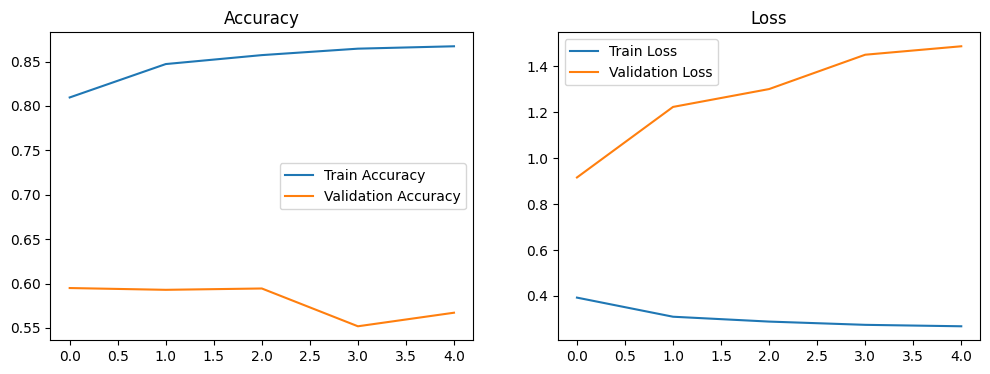

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

# Define dataset paths
real_video_dir = r'C:\project\dataset\FF++\real'
fake_video_dir = r'C:\project\dataset\FF++\fake'
frame_dir = r'C:\project\dataset\FF++\frames'
os.makedirs(frame_dir, exist_ok=True)
real_frame_dir = os.path.join(frame_dir, 'real')
fake_frame_dir = os.path.join(frame_dir, 'fake')
os.makedirs(real_frame_dir, exist_ok=True)
os.makedirs(fake_frame_dir, exist_ok=True)

def extract_frames(video_path, save_dir, max_frames=50):
    cap = cv2.VideoCapture(video_path)
    count = 0
    while cap.isOpened() and count < max_frames:
        ret, frame = cap.read()
        if not ret:
            break
        frame_path = os.path.join(save_dir, f"{os.path.basename(video_path)}_frame{count}.jpg")
        cv2.imwrite(frame_path, frame)
        count += 1
    cap.release()

# Extract frames from real and fake videos
for video in os.listdir(real_video_dir):
    extract_frames(os.path.join(real_video_dir, video), real_frame_dir)
for video in os.listdir(fake_video_dir):
    extract_frames(os.path.join(fake_video_dir, video), fake_frame_dir)

# Image Data Generator for preprocessing
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Load training data
train_data = datagen.flow_from_directory(
    frame_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

# Load validation data
val_data = datagen.flow_from_directory(
    frame_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

# Load pre-trained Xception model
base_model = keras.applications.Xception(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_model.trainable = False  # Freeze the base model

# Add custom layers for classification
model = keras.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_data, validation_data=val_data, epochs=5)

# Save the model
model.save('deepfake_detector.h5')

# Plot accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()
